In [1]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style="darkgrid")
import matplotlib.pyplot as plt
%matplotlib inline

import datetime
import time

In [2]:
import warnings
warnings.filterwarnings("ignore")

<h1>Yelp Data Exploration</h1>

In [3]:
def convertJSON (jsonFilename) :
    # read the entire file into a python array
    with open(jsonFilename, 'r') as f:
        data = f.readlines()

    # remove the trailing "\n" from each line
    data = map(lambda x: x.rstrip(), data)

    # each element of 'data' is an individual JSON object.
    # i want to convert it into an *array* of JSON objects
    # which, in and of itself, is one large JSON object
    # basically... add square brackets to the beginning
    # and end, and have all the individual business JSON objects
    # separated by a comma
    data_json_str = "[" + ','.join(data) + "]"

    # now, load it into pandas
    data_df = pd.read_json(data_json_str)
    
    return data_df

SHARED_FOLDER = './pickle'
with open ('{}/business.pickle'.format(SHARED_FOLDER), 'rb') as f:
    df_business = pickle.load(f)


with open ('{}/user.pickle'.format(SHARED_FOLDER), 'rb') as f:
    df_users = pickle.load(f)


with open ('{}/review.pickle'.format(SHARED_FOLDER), 'rb') as f:
     df_reviews = pickle.load(f)


with open ('{}/tip.pickle'.format(SHARED_FOLDER), 'rb') as f:
     df_tips = pickle.load(f)


In [4]:
base_path = './yelp/json'
df_business = convertJSON(base_path+'/businesses/yelp_academic_dataset_business.json')
print('Businesses Loaded....')
df_reviews = convertJSON(base_path+'/reviews/yelp_academic_dataset_review.json')
print('reviews Loaded....')
df_users = convertJSON(base_path+'/users/yelp_academic_dataset_user.json')
print('users Loaded....')
df_tips = convertJSON(base_path+'/tips/yelp_academic_dataset_tip.json')
print('tips Loaded....')

Businesses Loaded....
reviews Loaded....
users Loaded....
tips Loaded....


In [7]:
df_business_vegas = df_business[(df_business.city == 'Las Vegas')]


print('There are ', len(df_business_vegas), 'business in Las Vegas')


df_reviews_vegas = df_reviews[df_reviews.business_id.isin(df_business_vegas.business_id)]
df_reviews_vegas.date = df_reviews_vegas.date.apply(lambda x : x.to_datetime())

print('There are', len(df_reviews_vegas), 'reviews on those businesses')


df_tips_vegas = df_tips[df_tips.business_id.isin(df_business_vegas.business_id)]
df_tips_vegas.date = df_tips_vegas.date.apply(lambda x : x.to_datetime())

print('There are', len(df_tips_vegas), 'tips on those businesses')

df_users_vegas = df_users[df_users.user_id.isin(df_reviews_vegas.user_id) | df_users.user_id.isin(df_tips_vegas.user_id)]


print('There are', len(df_users_vegas), 'users corresponding to those reviews & tips')




There are  17423 business in Las Vegas
There are 861536 reviews on those businesses
There are 253748 tips on those businesses
There are 259396 users corresponding to those reviews & tips


In [8]:
df_users_vegas['friends_count'] = df_users_vegas.friends.apply(lambda x : len(x))

In [9]:
#Let's count tips
count_tips = df_tips_vegas.groupby(['user_id'], as_index=False).agg({
        "business_id" : "count"
    })

count_tips.columns = ['user_id', 'count_tips']

df_users_vegas = df_users_vegas.merge(count_tips, on='user_id')

In [10]:
#Let's count reviews
count_reviews = df_reviews_vegas.groupby(['user_id'], as_index=False).agg({
        "review_id" : "count"
    })

count_reviews.columns = ['user_id', 'count_reviews']

df_users_vegas = df_users_vegas.merge(count_reviews, on='user_id')

In [11]:
#let's count votes
df_users_vegas['count_votes'] = df_users_vegas.votes.apply(lambda x : x['cool'] + x['funny'] + x['useful'])

In [15]:
col = df_users_vegas.describe().columns
print(col)
df_users_vegas[col].sample(3000).to_csv('df_users_vegas.csv', index=False)

Index(['average_stars', 'fans', 'review_count', 'friends_count', 'count_tips',
       'count_reviews', 'count_votes'],
      dtype='object')


In [11]:
#Let's count the number of reviews on business
df_reviews_vegas['business_count'] = 1
df_reviews_vegas['business_count'] = df_reviews_vegas.groupby(['business_id'])['business_count'].cumsum()

#Add a Timestamp to the dataframe
df_reviews_vegas['timestamp'] = df_reviews_vegas['date'].apply(lambda x : x.timestamp())

In [12]:
#Reduce df_reviews_stars_size
rev_cols = ['user_id', 'business_id', 'review_id', 'date', 'business_count', 'timestamp', 'stars']
df_reviews_compute = df_reviews_vegas[rev_cols]

In [13]:
nb_days_after_review = 30 #1 month
nb_days_before_review = 4*30 #4 months

def computeInfluence (manif) :
    
    if((manif.name % 500) == 0):
        print(manif.name,'...')
    review_date = manif.date
    before_date = review_date - datetime.timedelta(days=nb_days_before_review)
    after_date = review_date + datetime.timedelta(days=nb_days_after_review)
    
    #Get the reviews on the business for the timelapse we need
    before_reviews = df_reviews_compute[(df_reviews_compute.business_id == manif.business_id) 
                                      & (df_reviews_compute.date > before_date) 
                                      & (df_reviews_compute.date <= review_date)]
    #before_reviews = df_business_vegas[(reviews.date <= review_date)]
    after_reviews = df_reviews_compute[(df_reviews_compute.business_id == manif.business_id) 
                                     & (df_reviews_compute.date > review_date) 
                                     & (df_reviews_compute.date <= after_date)]
    
    if (len(after_reviews) < 1) :
        #print('No reviews after the review', [len(after_reviews)])
        return 0
    elif (len(before_reviews) < 2) :  
        expected_reviews_count = manif.business_count
        max_timestamp = after_reviews['timestamp'].max()
        actual_reviews_count = after_reviews[after_reviews.timestamp == max_timestamp].business_count.values[0]
        influence = (actual_reviews_count - expected_reviews_count)/expected_reviews_count

        return influence
    
    # Plot the regression
    

    
    #Linear regression
    #regr = linear_model.SGDRegressor(alpha=0.1, n_iter=2, shuffle=False)
    X = before_reviews['timestamp'].values
    Y = before_reviews['business_count'].values
    #X = np.reshape(X, (len(X), 1))
    #Y = np.reshape(Y, (len(Y), 1))
    
    P = np.polyfit(X, Y, deg=1)
    
    #regr.fit(X, Y)
    
    
    #y = a*x + b
    a = P[0]
    b = P[1]
    
    #Expected review count on the after date
    expected_reviews_count = np.ceil(a*after_date.timestamp() + b)
    
    
    #Actual review count on the after date
    #since the reviews dataframe is sorted by date descending, we just have to take the last one on the list
    max_timestamp = after_reviews['timestamp'].max()
    actual_reviews_count = after_reviews[after_reviews.timestamp == max_timestamp].business_count.values[0]
    
    
    influence = (actual_reviews_count - expected_reviews_count)/expected_reviews_count
    
    if (influence == float("-inf")) :
        return 0   
    return influence

In [88]:
yelper_stars = df_users_vegas[df_users_vegas.count_reviews > 20]
print(len(yelper_stars), 'users choosen')

3317 users choosen


In [89]:
#Let's plot the reviews evolution on the business with the most reviews
businesses = df_business_vegas

#def computeBusinessInfluence(business) : 

reviews = df_reviews_vegas[df_reviews_vegas.user_id.isin(yelper_stars.user_id)][rev_cols]

reviews.sort_values(['date'], ascending=True, inplace=True)

reviews.reset_index(drop=True, inplace=True)

print(len(reviews), 'reviews to compute')
start_time = time.time()
reviews['influence'] = reviews.apply(computeInfluence, axis=1)
print("--- %s seconds ---" % (time.time() - start_time))
reviews.head()

185146 reviews to compute
0 ...
500 ...
1000 ...
1500 ...
2000 ...
2500 ...
3000 ...
3500 ...
4000 ...
4500 ...
5000 ...
5500 ...
6000 ...
6500 ...
7000 ...
7500 ...
8000 ...
8500 ...
9000 ...
9500 ...
10000 ...
10500 ...
11000 ...
11500 ...
12000 ...
12500 ...
13000 ...
13500 ...
14000 ...
14500 ...
15000 ...
15500 ...
16000 ...
16500 ...
17000 ...
17500 ...
18000 ...
18500 ...
19000 ...
19500 ...
20000 ...
20500 ...
21000 ...
21500 ...
22000 ...
22500 ...
23000 ...
23500 ...
24000 ...
24500 ...
25000 ...
25500 ...
26000 ...
26500 ...
27000 ...
27500 ...
28000 ...
28500 ...
29000 ...
29500 ...
30000 ...
30500 ...
31000 ...
31500 ...
32000 ...
32500 ...
33000 ...
33500 ...
34000 ...
34500 ...
35000 ...
35500 ...
36000 ...
36500 ...
37000 ...
37500 ...
38000 ...
38500 ...
39000 ...
39500 ...
40000 ...
40500 ...
41000 ...
41500 ...
42000 ...
42500 ...
43000 ...
43500 ...
44000 ...
44500 ...
45000 ...
45500 ...
46000 ...
46500 ...
47000 ...
47500 ...
48000 ...
48500 ...
49000 ...
49500 ..

,user_id,business_id,review_id,date,business_count,timestamp,stars,influence
0,pz97SxRe1Vk-5_K6EB9OSA,H6CJflwclNpttYrtsBMsVg,EtDRtrN9NlW9Iq1wG7ifCA,2005-04-27,1,1.114553e+09,4,0.000000
1,pz97SxRe1Vk-5_K6EB9OSA,GAA2AxjySMqN-p-n89SJIA,NCFzM4_rJgudIq2tP2494Q,2005-05-23,1,1.116799e+09,4,0.000000
2,pz97SxRe1Vk-5_K6EB9OSA,q_DrPmiLrHEpR_SQvQXELQ,NTfpT_NU6NMhVABGJRYxEQ,2005-05-23,2,1.116799e+09,5,0.000000
3,pW91HUnVz6ssLZ4dY-ztyQ,uYVdp5LfCbX8S8ytnhdk-g,q1P3ywvNh1eVYx9GSdZaMw,2005-10-05,2,1.128463e+09,5,0.333333
4,pW91HUnVz6ssLZ4dY-ztyQ,y6sNNP97UCSl_p2o5Wm40A,j4U7Ml23mCD6sVwI_fWfpg,2005-10-05,1,1.128463e+09,4,1.000000


In [90]:
reviews.to_csv('influence_reviews_all.csv', index=False)

In [96]:
global_ys = reviews.groupby(['user_id'], as_index=False).agg({
        'influence' : 'mean',
        'review_id' : 'count'
    })

global_ys.sort_values(['influence'], ascending=False, inplace=True)

global_ys = global_ys[global_ys.influence >= 0.1]

global_ys.columns = ['user_id', 'influence', 'nb_reviews']
print(len(global_ys), 'Yelpers Stars found!!!!!!!!!')

global_ys = global_ys.merge(df_users_vegas, on='user_id', how='inner')

global_ys.to_csv('global_yelper_stars.csv', as_index=False)

global_ys.head()

237 Yelpers Stars found!!!!!!!!!


,user_id,influence,nb_reviews,average_stars,compliments,elite,fans,friends,name,review_count,type,votes,yelping_since,friends_count,count_tips,count_reviews,count_votes,age
0,ZKHAt_d7INgVsNjsH14HhA,2.274584,24,4.40,"{'funny': 1, 'more': 1, 'plain': 3}",[],0,"[WmAyExqSWoiYZ5XEqpk_Uw, XFq2ztmqIH39-AgjW1dvP...",Jon,48,user,"{'funny': 8, 'cool': 19, 'useful': 28}",2012-10,6,52,24,55,1571
1,yvbuGvQKodq6PoRJ2whCfw,2.217477,23,3.82,{'plain': 1},[],1,"[WmAyExqSWoiYZ5XEqpk_Uw, TuyRP9kjDBQRJotLZ_nTB...",Alan,34,user,"{'funny': 16, 'cool': 18, 'useful': 41}",2013-01,26,11,23,75,1479
2,Z7o9ZUMdx3xS25_ICz25kA,1.506649,21,3.86,"{'hot': 1, 'note': 1, 'more': 1, 'funny': 4, '...",[],0,"[0UC74YrWi6m9f00VajWxwQ, J3wXKA-dlUgFlCOOCppnK...",Chris,55,user,"{'funny': 14, 'cool': 11, 'useful': 48}",2011-01,35,23,21,73,2210
3,XjaJ40tccsznT5NN-ut8Vw,1.456412,21,3.32,{},[],0,[dxM0vufCT-_2UNKgOSRKKg],Barbara,24,user,"{'funny': 9, 'cool': 6, 'useful': 19}",2011-07,1,2,21,34,2029
4,3loxGPOEyMZeTFLSphMLPg,1.453542,23,4.39,{'funny': 1},[],1,"[S6UftnZxBPkarTlOPAqpRA, RPIvPQ2a8sthQRZwzZDp1...",Darcy,41,user,"{'funny': 9, 'cool': 13, 'useful': 27}",2013-08,3,10,23,49,1267


In [92]:

users_group = reviews.groupby(['user_id', 'stars'], as_index=False).agg({
        'influence' : 'mean',
        'review_id' : 'count'
    })

#users_group.sort_values(['influence'], ascending=False, inplace=True)
print(len(users_group.user_id.unique()), 'uniques users')

3317 uniques users


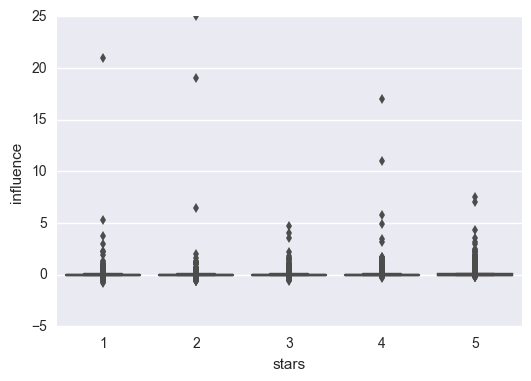

In [93]:
users_group.head()
sns.boxplot(data=users_group, x='stars', y='influence', orient='v')

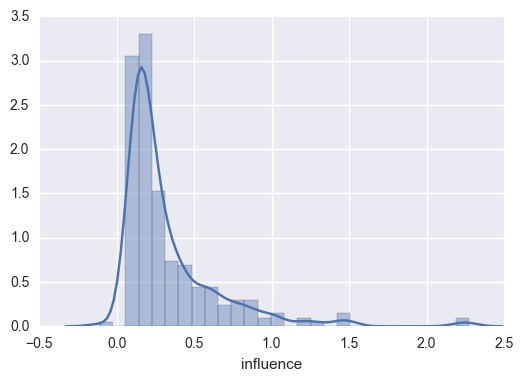

In [94]:
sns.distplot(global_ys.influence)

In [ ]:
aa = reviews.groupby(['user_id', 'stars'], as_index=False).agg({
        'review_id' : 'count',
        'influence' : 'mean'
    })

test = aa[(aa.stars >= 3) & (aa.influence > 0.05)]

test  = aa[aa.user_id.isin(test.user_id)
               & (reviews.stars < 3)
               & (reviews.influence < -0.05)]

bb = reviews[reviews.user_id.isin(test.user_id)].groupby(['user_id', 'stars'], as_index=False).agg({
        'review_id' : 'count',
        'influence' : 'mean'
    })
#aa.sort_values(['influence'], inplace=True, ascending=False)
bb

In [95]:
reviews.influence.describe()

count    185146.000000
mean          0.036437
std           0.765471
min          -0.928571
25%          -0.011976
50%           0.000000
75%           0.009524
max         115.000000
Name: influence, dtype: float64